In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import pickle
sns.set()
pd.options.display.max_columns=50

### Load Dataset

In [2]:
train_df = pd.read_csv('Processed_Train.csv')
eval_df = pd.read_csv('Processed_Eval.csv')
test_df = pd.read_csv('Processed_Test.csv')

In [3]:
train_df.head()

,id,member_id,Good_loan,Grade:A,Grade:B,Grade:C,Grade:D,Grade:E,Grade:F,Grade:G,Status:Not_Verified,Status:Source_Verified,Status:Verified,Loan:above_281,Loan:below_74,Loan:bet_143_212,Loan:bet_212_281,Loan:bet_74_143,Term:36,Term:60,DTI:above_32,DTI:below_8,DTI:bet_16_24,DTI:bet_24_32,DTI:bet_8_16,Purpose:cat_1,Purpose:cat_2,Purpose:cat_3,Purpose:cat_4,Purpose:cat_5,Purpose:small_business
0,14408288,16460681,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6916410,8558441,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3016965,3629395,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1033888,1263473,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,11675673,13647823,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
X_train = train_df.drop(['id','member_id','Good_loan'],axis='columns')
y_train = train_df['Good_loan']

In [5]:
X_eval = eval_df.drop(['id','member_id','Good_loan'],axis='columns')
y_eval = eval_df['Good_loan']

In [6]:
X_test = test_df.drop(['id','member_id'],axis='columns')

### Dropping one column for each category to avoid dummy variable trap/multicollinearity issue

In [7]:
# dropping Grade:G for grade. Grade G becomes the reference grade.
# similary dropping Status:Verified, Loan:below_74, Term:60, DTI:below_8, Purpose:small_business
drop_col = ['Grade:G','Status:Verified','Loan:below_74','Term:60','DTI:below_8','Purpose:small_business']
X_train.drop(drop_col,axis='columns',inplace=True)
X_eval.drop(drop_col,axis='columns',inplace=True)
X_test.drop(drop_col,axis='columns',inplace=True)

### Fitting Logistic Regression Model

In [8]:
class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [9]:
# Class weighting for imbalance class
compute_class_weight('balanced', np.unique(y_train), y_train)

array([2.67467628, 0.61495964])

In [10]:
model = LogisticReg(class_weight={0:2.5,1:1},random_state=42)
model.fit(X_train,y_train)

### Coefficients Significance

In [11]:
coeff = model.model.coef_
coeff = coeff[0]
coeff

array([ 1.95742577,  1.25427292,  0.79795227,  0.48778484,  0.24236656,
        0.0778732 ,  0.04063669, -0.03238287,  0.09577484, -0.03795101,
       -0.00200728, -0.04247885,  0.38062436, -0.79599446, -0.38896967,
       -0.66882967, -0.15729815,  0.44095324,  0.55901378,  0.61251684,
        0.67076881,  0.57053955])

In [12]:
intercept = model.model.intercept_
intercept = intercept[0]
intercept

-0.8703085230070996

In [13]:
summary = pd.DataFrame({'Feature': X_train.columns, 'coeff': coeff,'p_val':model.p_values})
summary['p_val'] = summary['p_val'].round(2)
summary.loc[summary.index[-1] + 1,:] =['Intercept',intercept,0]
summary

,Feature,coeff,p_val
0,Grade:A,1.957426,0.00
1,Grade:B,1.254273,0.00
2,Grade:C,0.797952,0.00
3,Grade:D,0.487785,0.00
4,Grade:E,0.242367,0.00
5,Grade:F,0.077873,0.07
6,Status:Not_Verified,0.040637,0.00
7,Status:Source_Verified,-0.032383,0.01
8,Loan:above_281,0.095775,0.00
9,Loan:bet_143_212,-0.037951,0.02


The only feature which is not significant is "Loan:bet_212_281" as pvalue is 0.92 much greater than 0.05. But still we will keep this feature in our model as other categories for "Loan" feature are significant

### Precision Recall Curve

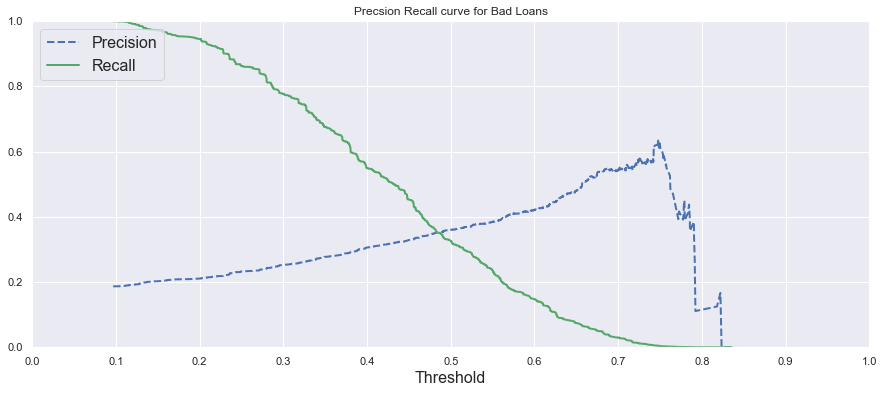

In [14]:
#ROC curves are appropriate when the observations are balanced between each class, 
# whereas precision-recall curves are appropriate for imbalanced datasets
# since we have imbalance dataset we will use prcesison recall curve

# plotting precsion recall curve for bad loan as we are more interesetd in classifying Bad loans

# Bad Loan probabilites
y_hat_eval_prob = model.model.predict_proba(X_eval)
y_hat_eval_prob  = y_hat_eval_prob[:,0]

# converting y_val label 1 from Good Loan to bad loan
actual = ~(y_eval.astype(bool))
actual = actual.astype(int)

precisions, recalls, thresholds = precision_recall_curve(actual, y_hat_eval_prob)

plt.figure(figsize=(15, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.title('Precsion Recall curve for Bad Loans')
plt.show()

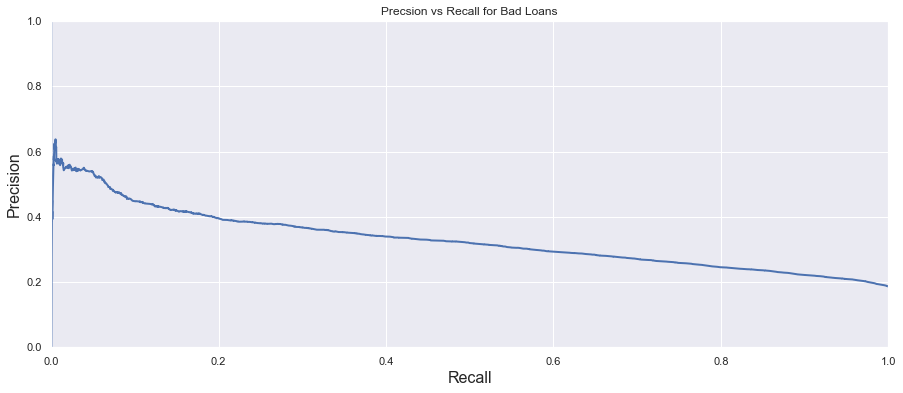

In [15]:
plt.figure(figsize=(15, 6))
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('Precsion vs Recall for Bad Loans')
plt.show()

From graph 1 we can see that both precision recall meet at 0.55 threshold for bad loan or 0.45 for good loanbr<br>
From graph 2 we can seee that 0.4 precision we have 0.4 recall.

### Evaluating Model Accuracy at 0.45 threshold

In [16]:
# Label 1 indicates Good Loan i.e. Not Defaulted  Label 0 indicated Bad Loan i.e. Defaulted
y_hat_eval = model.model.predict_proba(X_eval)
y_hat_eval = y_hat_eval[:,1]
y_hat_eval =y_hat_eval >=0.45
print(classification_report(y_eval, y_hat_eval,))
print('----------------------------------------------')
print("Accuracy: ", accuracy_score(y_eval, y_hat_eval))
print("f1_score: ", f1_score(y_eval, y_hat_eval))

              precision    recall  f1-score   support

           0       0.38      0.24      0.29      8495
           1       0.84      0.91      0.87     36948

    accuracy                           0.79     45443
   macro avg       0.61      0.57      0.58     45443
weighted avg       0.75      0.79      0.77     45443

----------------------------------------------
Accuracy:  0.7865677882182074
f1_score:  0.8743245869776481


In [17]:
confusion_matrix = pd.DataFrame({'Actual':y_eval,'Predicted':y_hat_eval})
confusion_matrix.replace({1:'Good Loan',0:'Bad Loan'},inplace=True)
confusion_matrix = confusion_matrix.groupby(['Actual','Predicted']).size().unstack()
confusion_matrix['sum'] = confusion_matrix.sum(axis=1)
confusion_matrix.loc['sum',:] = confusion_matrix[['Bad Loan','Good Loan']].sum(axis=0)
confusion_matrix.at['sum','sum'] = confusion_matrix['sum'].sum()
confusion_matrix.astype(int)

Predicted,Bad Loan,Good Loan,sum
Actual,,,
Bad Loan,2006,6489,8495
Good Loan,3210,33738,36948
sum,5216,40227,45443


In [18]:
# Normalized confusion matrix
(confusion_matrix/confusion_matrix.at['sum','sum'])*100

Predicted,Bad Loan,Good Loan,sum
Actual,,,
Bad Loan,4.414321,14.279427,18.693748
Good Loan,7.063794,74.242458,81.306252
sum,11.478115,88.521885,100.000000


### Evaluating Model Accuracy at default 0.5 threshold

In [19]:
# Label 1 indicates Good Loan i.e. Not Defaulted  Label 0 indicated Bad Loan i.e. Defaulted
y_hat_eval = model.model.predict(X_eval)
print(classification_report(y_eval, y_hat_eval,))
print('----------------------------------------------')
print("Accuracy: ", accuracy_score(y_eval, y_hat_eval))
print("f1_score: ", f1_score(y_eval, y_hat_eval))

              precision    recall  f1-score   support

           0       0.36      0.33      0.34      8495
           1       0.85      0.87      0.86     36948

    accuracy                           0.77     45443
   macro avg       0.60      0.60      0.60     45443
weighted avg       0.76      0.77      0.76     45443

----------------------------------------------
Accuracy:  0.7657505006271593
f1_score:  0.8574871142646763


In [20]:
confusion_matrix = pd.DataFrame({'Actual':y_eval,'Predicted':y_hat_eval})
confusion_matrix.replace({1:'Good Loan',0:'Bad Loan'},inplace=True)
confusion_matrix = confusion_matrix.groupby(['Actual','Predicted']).size().unstack()
confusion_matrix['sum'] = confusion_matrix.sum(axis=1)
confusion_matrix.loc['sum',:] = confusion_matrix[['Bad Loan','Good Loan']].sum(axis=0)
confusion_matrix.at['sum','sum'] = confusion_matrix['sum'].sum()
confusion_matrix.astype(int)

Predicted,Bad Loan,Good Loan,sum
Actual,,,
Bad Loan,2773,5722,8495
Good Loan,4923,32025,36948
sum,7696,37747,45443


In [21]:
# Normalized confusion matrix
(confusion_matrix/confusion_matrix.at['sum','sum'])*100

Predicted,Bad Loan,Good Loan,sum
Actual,,,
Bad Loan,6.102150,12.591598,18.693748
Good Loan,10.833352,70.472900,81.306252
sum,16.935502,83.064498,100.000000


# Model Performance Evaluation 

### CAP Curve

In [22]:
y_hat_eval_prob = model.model.predict_proba(X_eval)
predict_df = pd.DataFrame({'Actual':y_eval,'Predicted':y_hat_eval})
predict_df['Bad_prob'] = y_hat_eval_prob[:,0]
predict_df['Good_prob'] = y_hat_eval_prob[:,1]
predict_df.sort_values(by=['Good_prob'],inplace=True)
predict_df.head()

,Actual,Predicted,Bad_prob,Good_prob
6901,1,0,0.835673,0.164327
21206,1,0,0.829433,0.170567
1222,1,0,0.823631,0.176369
10174,1,0,0.823631,0.176369
39017,0,0,0.822240,0.177760


In [23]:
predict_df.tail()

,Actual,Predicted,Bad_prob,Good_prob
20314,1,1,0.101639,0.898361
1418,1,1,0.098263,0.901737
2422,1,1,0.096714,0.903286
20185,0,1,0.096714,0.903286
6714,1,1,0.096714,0.903286


In [24]:
# computing cumulative count
predict_df = predict_df.reset_index()
predict_df['cumulative_population'] = predict_df.index+1
predict_df['cumulative_good'] = predict_df['Actual'].cumsum()
predict_df['cumulative_bad'] = predict_df['cumulative_population'] - predict_df['cumulative_good']
predict_df.head()

,index,Actual,Predicted,Bad_prob,Good_prob,cumulative_population,cumulative_good,cumulative_bad
0,6901,1,0,0.835673,0.164327,1,1,0
1,21206,1,0,0.829433,0.170567,2,2,0
2,1222,1,0,0.823631,0.176369,3,3,0
3,10174,1,0,0.823631,0.176369,4,4,0
4,39017,0,0,0.822240,0.177760,5,4,1


In [25]:
# computing cumulative percentage
predict_df['cumulative_per_population'] = predict_df['cumulative_population']/predict_df.shape[0]
predict_df['cumulative_per_good'] = predict_df['cumulative_good']/predict_df['Actual'].sum()
predict_df['cumulative_per_bad'] = predict_df['cumulative_bad']/(predict_df.shape[0]- predict_df['Actual'].sum())
predict_df.head()

,index,Actual,Predicted,Bad_prob,Good_prob,cumulative_population,cumulative_good,cumulative_bad,cumulative_per_population,cumulative_per_good,cumulative_per_bad
0,6901,1,0,0.835673,0.164327,1,1,0,0.000022,0.000027,0.000000
1,21206,1,0,0.829433,0.170567,2,2,0,0.000044,0.000054,0.000000
2,1222,1,0,0.823631,0.176369,3,3,0,0.000066,0.000081,0.000000
3,10174,1,0,0.823631,0.176369,4,4,0,0.000088,0.000108,0.000000
4,39017,0,0,0.822240,0.177760,5,4,1,0.000110,0.000108,0.000118


In [26]:
predict_df.tail()

,index,Actual,Predicted,Bad_prob,Good_prob,cumulative_population,cumulative_good,cumulative_bad,cumulative_per_population,cumulative_per_good,cumulative_per_bad
45438,20314,1,1,0.101639,0.898361,45439,36945,8494,0.999912,0.999919,0.999882
45439,1418,1,1,0.098263,0.901737,45440,36946,8494,0.999934,0.999946,0.999882
45440,2422,1,1,0.096714,0.903286,45441,36947,8494,0.999956,0.999973,0.999882
45441,20185,0,1,0.096714,0.903286,45442,36947,8495,0.999978,0.999973,1.000000
45442,6714,1,1,0.096714,0.903286,45443,36948,8495,1.000000,1.000000,1.000000


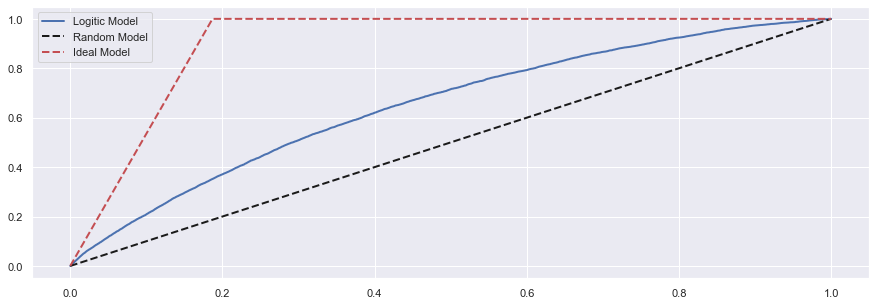

In [27]:
x_axis = predict_df['cumulative_per_population']
y_axis = predict_df['cumulative_per_bad']
default_rate =  1-predict_df['Actual'].mean()
plt.figure(figsize=(15,5))
plt.plot(x_axis,y_axis,c = 'b',label = 'Logitic Model',linewidth = 2) 
plt.plot(x_axis,x_axis,c = 'k',label = 'Random Model',linestyle='--',linewidth = 2) 
plt.plot([0,default_rate,1],[0,1,1],c = 'r',label = 'Ideal Model',linestyle='--',linewidth = 2) 
plt.legend()

From graph we can see that our model is better than random guessing but still way off from ideal model

### ROC Curve

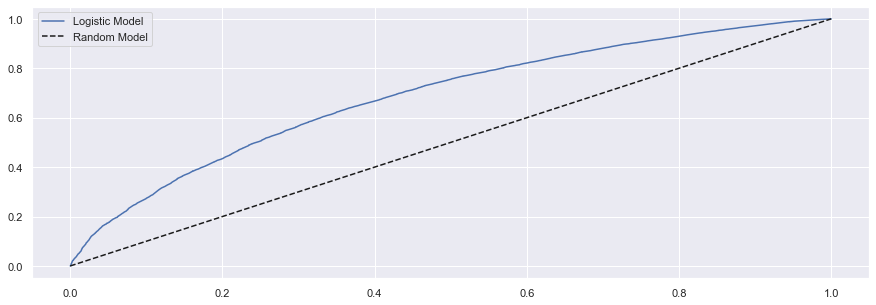

In [28]:
y_hat_eval_prob = model.model.predict_proba(X_eval)
y_hat_eval_prob = y_hat_eval_prob[:,1]
fpr,tpr,thresholds = roc_curve(y_eval,y_hat_eval_prob)
plt.figure(figsize=(15,5))
plt.plot(fpr,tpr,label='Logistic Model')
plt.plot(fpr,fpr,linestyle='--',color='k',label='Random Model')
plt.legend()

In [29]:
area_roc = roc_auc_score(y_eval,y_hat_eval_prob)
area_roc

0.6851474318009759

Area user ROC Curve is 0.68 which >0.5(random model)

### Gini Coefficient or Somers’ D

In [30]:
gini = 2*area_roc - 1
gini

0.37029486360195185

a credit score model with Somers’ D of >= 0.4 is deemed to be good

### Kolmogorov-Smirnoff Statistic (KS)

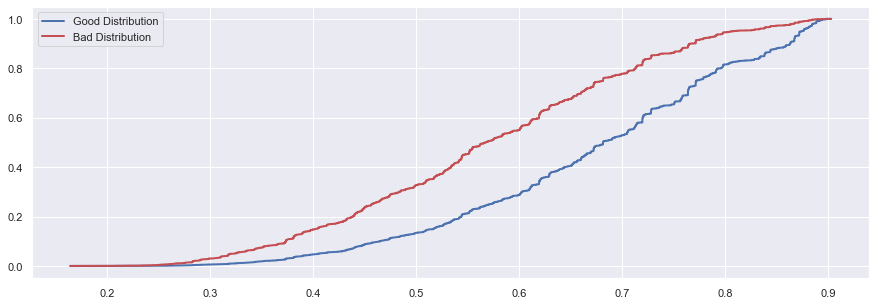

In [31]:
x_axis = predict_df['Good_prob']
plt.figure(figsize=(15,5))
plt.plot(x_axis,predict_df['cumulative_per_good'],c = 'b',label = 'Good Distribution',linewidth = 2) 
plt.plot(x_axis,predict_df['cumulative_per_bad'],c = 'r',label = 'Bad Distribution',linewidth = 2) 
plt.legend()
plt.show()

In [32]:
ks_statistic = max(predict_df['cumulative_per_bad']-predict_df['cumulative_per_good'] )
ks_statistic

0.2732371562967804

ks_statistic = 0 worst model, ks_statistic = 1 best model, we see ks is low but it is greater 0

### Creating Credit Scorecard

In [33]:
# adding ref categories for dummy variables
reference_cat = pd.DataFrame({'Feature':drop_col, 'coeff':0,'p_val':0})
reference_cat

,Feature,coeff,p_val
0,Grade:G,0,0
1,Status:Verified,0,0
2,Loan:below_74,0,0
3,Term:60,0,0
4,DTI:below_8,0,0
5,Purpose:small_business,0,0


In [34]:
summary = summary.append(reference_cat,sort=False)
summary = summary.reset_index(drop=True)
summary.head()

,Feature,coeff,p_val
0,Grade:A,1.957426,0.0
1,Grade:B,1.254273,0.0
2,Grade:C,0.797952,0.0
3,Grade:D,0.487785,0.0
4,Grade:E,0.242367,0.0


In [35]:
# create orignal feature name
summary['Original_Feature'] = summary['Feature'].str.split(':').str[0]
summary.head()

,Feature,coeff,p_val,Original_Feature
0,Grade:A,1.957426,0.0,Grade
1,Grade:B,1.254273,0.0,Grade
2,Grade:C,0.797952,0.0,Grade
3,Grade:D,0.487785,0.0,Grade
4,Grade:E,0.242367,0.0,Grade


In [36]:
# defining min and max score
min_score = 300
max_score = 850

In [37]:
summary.groupby(['Original_Feature'])['coeff'].min()

Original_Feature
DTI         -0.795994
Grade        0.000000
Intercept   -0.870309
Loan        -0.042479
Purpose      0.000000
Status      -0.032383
Term         0.000000
Name: coeff, dtype: float64

In [38]:
# all coeff minium value will correspond to lowest probbailtiy of good
min_value_coeff = summary.groupby(['Original_Feature'])['coeff'].min().sum()
min_value_coeff

-1.741164706068967

In [39]:
# all coeff max  value will correspond to highest probbailtiy of good
max_value_coeff = summary.groupby(['Original_Feature'])['coeff'].max().sum()
max_value_coeff

2.2749219581458036

In [40]:
# compute scale factor for converting coeff to 300-850 scale
scale_factor = (max_score-min_score)/(max_value_coeff-min_value_coeff)
scale_factor

136.94923590687418

In [41]:
summary['Score'] = summary['coeff'] * scale_factor
summary

,Feature,coeff,p_val,Original_Feature,Score
0,Grade:A,1.957426,0.00,Grade,268.067964
1,Grade:B,1.254273,0.00,Grade,171.771718
2,Grade:C,0.797952,0.00,Grade,109.278954
3,Grade:D,0.487785,0.00,Grade,66.801761
4,Grade:E,0.242367,0.00,Grade,33.191915
5,Grade:F,0.077873,0.07,Grade,10.664676
6,Status:Not_Verified,0.040637,0.00,Status,5.565164
7,Status:Source_Verified,-0.032383,0.01,Status,-4.434809
8,Loan:above_281,0.095775,0.00,Loan,13.116291
9,Loan:bet_143_212,-0.037951,0.02,Loan,-5.197362


In [42]:
# Adjusting intercept
# first making intercept into the scale of max_coeff - min coeff scale
# then converting it to 300-850 score
# formula used (x-min_coeff)/(max_coeff -min_coeff) for converting to coeff scale
# then z = (max_score-min_score) * X + min_score for converting it to 300-850 score

intercept_index = summary.index[summary['Original_Feature'] == 'Intercept']
summary.loc[intercept_index,'Score']=(summary.loc[intercept_index,'coeff'] - min_value_coeff)/(max_value_coeff-min_value_coeff)*(max_score-min_score)+min_score 
summary

,Feature,coeff,p_val,Original_Feature,Score
0,Grade:A,1.957426,0.00,Grade,268.067964
1,Grade:B,1.254273,0.00,Grade,171.771718
2,Grade:C,0.797952,0.00,Grade,109.278954
3,Grade:D,0.487785,0.00,Grade,66.801761
4,Grade:E,0.242367,0.00,Grade,33.191915
5,Grade:F,0.077873,0.07,Grade,10.664676
6,Status:Not_Verified,0.040637,0.00,Status,5.565164
7,Status:Source_Verified,-0.032383,0.01,Status,-4.434809
8,Loan:above_281,0.095775,0.00,Loan,13.116291
9,Loan:bet_143_212,-0.037951,0.02,Loan,-5.197362


In [43]:
summary['Score'] = summary['Score'].round()

In [44]:
summary.groupby(['Original_Feature'])['Score'].min().sum()

300.0

In [45]:
summary.groupby(['Original_Feature'])['Score'].max().sum()

850.0

we have successfully converted the coefficients to 300-850 score

### Computing Credit Score for test data set

In [46]:
test_credit_score = test_df.drop(['id','member_id'],axis='columns')
test_credit_score.head()

,Grade:A,Grade:B,Grade:C,Grade:D,Grade:E,Grade:F,Grade:G,Status:Not_Verified,Status:Source_Verified,Status:Verified,Loan:above_281,Loan:below_74,Loan:bet_143_212,Loan:bet_212_281,Loan:bet_74_143,Term:36,Term:60,DTI:above_32,DTI:below_8,DTI:bet_16_24,DTI:bet_24_32,DTI:bet_8_16,Purpose:cat_1,Purpose:cat_2,Purpose:cat_3,Purpose:cat_4,Purpose:cat_5,Purpose:small_business
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
#adding intercept
test_credit_score.insert(0,'Intercept',1)
test_credit_score.head()

,Intercept,Grade:A,Grade:B,Grade:C,Grade:D,Grade:E,Grade:F,Grade:G,Status:Not_Verified,Status:Source_Verified,Status:Verified,Loan:above_281,Loan:below_74,Loan:bet_143_212,Loan:bet_212_281,Loan:bet_74_143,Term:36,Term:60,DTI:above_32,DTI:below_8,DTI:bet_16_24,DTI:bet_24_32,DTI:bet_8_16,Purpose:cat_1,Purpose:cat_2,Purpose:cat_3,Purpose:cat_4,Purpose:cat_5,Purpose:small_business
0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
feature = test_credit_score.columns
score = summary[['Feature','Score']].copy().set_index('Feature')
score = score.loc[feature,:]
score

,Score
Intercept,419.0
Grade:A,268.0
Grade:B,172.0
Grade:C,109.0
Grade:D,67.0
Grade:E,33.0
Grade:F,11.0
Grade:G,0.0
Status:Not_Verified,6.0
Status:Source_Verified,-4.0


In [49]:
# Computing credit score with using dot product
final_score = test_credit_score.dot(score)
final_score.head()

,Score
0,594.0
1,559.0
2,547.0
3,610.0
4,428.0


In [50]:
# adding id
final_score['id'] = test_df['id']

# adding probability
proba = model.model.predict_proba(X_test)
proba = proba[:,1]
final_score['Good_prob'] = proba
final_score['Good_prob'] = final_score['Good_prob'].round(2)

In [51]:
final_score = final_score[['id','Score','Good_prob']].copy()
final_score.sample(5)

,id,Score,Good_prob
138594,23864274,664.0,0.71
185504,15419497,524.0,0.47
10555,8981612,689.0,0.75
93802,32459762,510.0,0.45
217186,10756854,675.0,0.73


In [52]:
# save the score
score.to_csv('score.csv')

In [53]:
# save the pd model
pickle.dump(model.model, open("PD_Model.pkl","wb"))